In [51]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


SECRET_FP = "./secrets.json"
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

sys.path.append(r"C:\Users\msands\OneDrive\Documents\code\submodules")
from eodhd import  Chain, ChainHistory, Security, Index
import plot
from plot import ChartStyle
cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Retrieval

In [52]:
etf_map = {
    "SP500": "SPY", # S&P 500 Index
    "R1KG": "IWF",  # Russell 1000 Growth Index
    "R1KV": "IWD",  # Russell 1000 Value Index
    "R2K": "IWM",   # Russell 2000 Index
    'RMC': "IWR",   # Russell Midcap Index
    "RMCG": "IWP",  # Russell Midcap Growth Index
    "RMCV": "IWS",  # Russell Midcap Value Index
    "INT": "EFA",   # MSCI EAFE Index (International Developed)
    "EM": "EEM",    # MSCI Emerging Markets Index
    "R3K": "IWV",   # Russell 3000 Index
    "ACWI": "ACWI", # MSCI All Country World Index
    "R25K": "SMMD" # Russell 2500 Index
}

sec = Security(ticker=list(etf_map.values()), start='2000-01-01')

# Create reverse mapping (ETF ticker -> Index name)
reverse_map = {v: k for k, v in etf_map.items()}

prices = sec.prices.rename(columns=reverse_map)
returns = sec.returns.rename(columns=reverse_map)

returns.index = pd.to_datetime(returns.index)

In [53]:
prices

ticker,ACWI,EM,INT,R1KV,R1KG,R2K,RMCG,RMC,RMCV,R3K,R25K,SP500
date,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.8845
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.2913
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.4492
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0277
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0820
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-21,136.84,53.10,92.65,203.04,457.60,235.60,133.57,93.47,136.68,373.81,71.70,659.0300
2025-11-24,138.36,53.66,92.73,204.48,467.73,239.90,134.70,94.18,137.56,378.80,72.83,668.7300
2025-11-25,139.62,53.85,93.84,207.26,471.02,245.13,137.06,95.70,139.80,383.05,74.28,675.0200


In [54]:
returns

ticker,ACWI,EM,INT,R1KV,R1KG,R2K,RMCG,RMC,RMCV,R3K,R25K,SP500
date,,,,,,,,,,,,
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.039891
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001787
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016202
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056453
2000-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003425
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-21,0.009841,-0.000188,0.015336,0.015386,0.005808,0.027933,0.013947,0.019227,0.020923,0.012138,0.023281,0.009912
2025-11-24,0.011047,0.010491,0.000863,0.007067,0.021896,0.018087,0.008424,0.007567,0.006418,0.013261,0.015637,0.014611
2025-11-25,0.009065,0.003535,0.011899,0.013504,0.007009,0.021567,0.017369,0.016010,0.016153,0.011157,0.019714,0.009362


# Regression Functions

In [55]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.optimize import minimize

def style_regression(returns_df, dependent_var, independent_vars, years=None, end_date=None, constrained=False, long_only=False):
    """
    Perform style regression analysis to identify characteristics of an index.
    
    Parameters:
    -----------
    returns_df : pd.DataFrame
        DataFrame of returns with datetime index
    dependent_var : str
        Column name of the dependent variable (the index to analyze)
    independent_vars : list of str
        List of column names for independent variables (style factors)
    years : int or 'full', optional
        Number of years of historical data to use. 
        Use 'full' or None to use all available data.
    end_date : str or datetime, optional
        End date for the regression period. If None, uses the latest date.
    constrained : bool, optional
        If True, constrains betas to sum to 1 and removes intercept.
        Betas can be negative unless long_only=True. Default is False.
    long_only : bool, optional
        Only applies when constrained=True. If True, constrains betas to be >= 0.
        This represents long-only portfolio weights. Default is False.
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'betas': dict of beta coefficients for each independent variable
        - 'pvalues': dict of p-values for each independent variable (None if constrained)
        - 'rsquared': R-squared value
        - 'adj_rsquared': Adjusted R-squared value
        - 'f_statistic': F-statistic for overall model significance (None if constrained)
        - 'f_pvalue': P-value for F-statistic (None if constrained)
        - 'period': tuple of (start_date, end_date) used in regression
        - 'n_observations': number of observations
    """
    
    # Filter data by time period
    df = returns_df.copy()
    
    if end_date is not None:
        df = df[df.index <= pd.to_datetime(end_date)]
    
    if years is not None and years != 'full':
        start_date = df.index.max() - pd.DateOffset(years=years)
        df = df[df.index >= start_date]
    
    # Drop NaN values
    cols_needed = [dependent_var] + independent_vars
    df_clean = df[cols_needed].dropna()
    
    if len(df_clean) == 0:
        raise ValueError("No valid data available for the specified period and variables")
    
    # Prepare X and y
    X = df_clean[independent_vars].values
    y = df_clean[dependent_var].values
    
    n = len(y)
    k = len(independent_vars)
    
    if constrained:
        # Constrained regression: betas sum to 1, no intercept
        # Betas can be positive or negative (e.g., long/short positions)
        
        def objective(betas):
            """Sum of squared residuals"""
            y_pred = X @ betas
            return np.sum((y - y_pred) ** 2)
        
        # Constraint: sum of betas = 1
        constraints = {'type': 'eq', 'fun': lambda b: np.sum(b) - 1}
        
        # Optional bounds for long-only constraint
        bounds = [(0, None) for _ in range(k)] if long_only else None
        
        # Initial guess: equal weights
        initial_guess = np.ones(k) / k
        
        # Optimize
        result = minimize(objective, initial_guess, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")
        
        betas = result.x
        y_pred = X @ betas
        residuals = y - y_pred
        
        # Calculate R-squared
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum(residuals ** 2)
        r_squared = 1 - (ss_residual / ss_total)
        adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k))
        
        # No statistical tests for constrained regression
        results = {
            'betas': {var: beta for var, beta in zip(independent_vars, betas)},
            'pvalues': None,
            'rsquared': r_squared,
            'adj_rsquared': adj_r_squared,
            'f_statistic': None,
            'f_pvalue': None,
            'period': (df_clean.index.min(), df_clean.index.max()),
            'n_observations': n,
            'intercept': 0.0,
            'intercept_pvalue': None,
            'constrained': True
        }
        
    else:
        # Standard OLS regression
        # Perform regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Calculate statistics
        y_pred = model.predict(X)
        residuals = y - y_pred
        
        # R-squared
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum(residuals ** 2)
        r_squared = 1 - (ss_residual / ss_total)
        
        # Adjusted R-squared
        adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        
        # Calculate p-values
        mse = ss_residual / (n - k - 1)
        var_coef = mse * np.linalg.inv(X.T @ X).diagonal()
        se_coef = np.sqrt(var_coef)
        t_stats = model.coef_ / se_coef
        p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - k - 1)) for t in t_stats]
        
        # Calculate F-statistic for overall model significance
        ss_explained = ss_total - ss_residual
        msr = ss_explained / k
        f_statistic = msr / mse
        f_pvalue = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
        
        # Prepare results
        results = {
            'betas': {var: beta for var, beta in zip(independent_vars, model.coef_)},
            'pvalues': {var: pval for var, pval in zip(independent_vars, p_values)},
            'rsquared': r_squared,
            'adj_rsquared': adj_r_squared,
            'f_statistic': f_statistic,
            'f_pvalue': f_pvalue,
            'period': (df_clean.index.min(), df_clean.index.max()),
            'n_observations': n,
            'intercept': model.intercept_,
            'intercept_pvalue': 2 * (1 - stats.t.cdf(np.abs(model.intercept_ / np.sqrt(mse / n)), n - k - 1)),
            'constrained': False
        }
    
    return results

def print_regression_results(results, dependent_var):
    """
    Display regression results in a clear DataFrame format.
    
    Parameters:
    -----------
    results : dict
        Output from style_regression function
    dependent_var : str
        Name of the dependent variable
    
    Returns:
    --------
    tuple : (summary_df, coefficients_df)
        - summary_df: DataFrame with model statistics
        - coefficients_df: DataFrame with beta coefficients and p-values
    """
    from IPython.display import display
    
    # Create summary statistics DataFrame
    summary_data = {
        'Metric': [],
        'Value': []
    }
    
    summary_data['Metric'].append('Dependent Variable')
    summary_data['Value'].append(dependent_var)
    
    summary_data['Metric'].append('Model Type')
    summary_data['Value'].append('Constrained (Σβ=1)' if results.get('constrained', False) else 'Unconstrained OLS')
    
    summary_data['Metric'].append('Period Start')
    summary_data['Value'].append(results['period'][0].strftime('%Y-%m-%d'))
    
    summary_data['Metric'].append('Period End')
    summary_data['Value'].append(results['period'][1].strftime('%Y-%m-%d'))
    
    summary_data['Metric'].append('Observations')
    summary_data['Value'].append(results['n_observations'])
    
    summary_data['Metric'].append('R-squared')
    summary_data['Value'].append(f"{results['rsquared']:.6f}")
    
    summary_data['Metric'].append('Adjusted R-squared')
    summary_data['Value'].append(f"{results['adj_rsquared']:.6f}")
    
    if results['f_statistic'] is not None:
        summary_data['Metric'].append('F-statistic')
        summary_data['Value'].append(f"{results['f_statistic']:.6f}")
        
        summary_data['Metric'].append('F-statistic p-value')
        summary_data['Value'].append(f"{results['f_pvalue']:.6e}")
    
    if not results.get('constrained', False):
        summary_data['Metric'].append('Intercept')
        summary_data['Value'].append(f"{results['intercept']:.6f}")
        
        summary_data['Metric'].append('Intercept p-value')
        summary_data['Value'].append(f"{results['intercept_pvalue']:.6f}")
    
    if results.get('constrained', False):
        beta_sum = sum(results['betas'].values())
        summary_data['Metric'].append('Sum of Betas')
        summary_data['Value'].append(f"{beta_sum:.6f}")
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create coefficients DataFrame
    coef_data = {
        'Variable': [],
        'Beta': [],
        'P-value': [],
        'Significance': []
    }
    
    for var in results['betas'].keys():
        coef_data['Variable'].append(var)
        coef_data['Beta'].append(results['betas'][var])
        
        if results['pvalues'] is not None:
            pval = results['pvalues'][var]
            coef_data['P-value'].append(pval)
            
            if pval < 0.001:
                sig = "***"
            elif pval < 0.01:
                sig = "**"
            elif pval < 0.05:
                sig = "*"
            else:
                sig = ""
            coef_data['Significance'].append(sig)
        else:
            coef_data['P-value'].append(None)
            coef_data['Significance'].append('')
    
    coefficients_df = pd.DataFrame(coef_data)
    
    # Display both DataFrames
    print(f"\n{'='*70}")
    print(f"Style Regression Results: {dependent_var}")

    if results['constrained']:
        print(" (Constrained Regression: Betas sum to 1)")

    print(f"{'='*70}\n")
    
    print("Model Summary:")
    display(summary_df)
    
    print("\nCoefficients:")
    display(coefficients_df)
    
    if results['pvalues'] is not None:
        print("\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001")
    
    print(f"{'='*70}\n")
    
    return summary_df, coefficients_df

In [56]:
def rolling_style_regression(returns_df, dependent_var, independent_vars, window_years, step_days=1, constrained=False, long_only=False):
    """
    Perform rolling style regression analysis over time.
    
    Parameters:
    -----------
    returns_df : pd.DataFrame
        DataFrame of returns with datetime index
    dependent_var : str
        Column name of the dependent variable (the index to analyze)
    independent_vars : list of str
        List of column names for independent variables (style factors)
    window_years : int
        Size of the rolling window in years
    step_days : int, optional
        Number of days to move forward for each regression. Default is 1 (daily).
        Use larger values (e.g., 5, 21, 63) for weekly, monthly, or quarterly steps.
    constrained : bool, optional
        If True, constrains betas to sum to 1 and removes intercept.
        Betas can be negative unless long_only=True. Default is False.
    long_only : bool, optional
        Only applies when constrained=True. If True, constrains betas to be >= 0.
        This represents long-only portfolio weights. Default is False.
    
    Returns:
    --------
    pd.DataFrame : DataFrame with rolling regression results indexed by end date of each window.
                   Columns include betas, p-values (if unconstrained), R-squared for each period.
    """
    
    df = returns_df.copy()
    cols_needed = [dependent_var] + independent_vars
    df_clean = df[cols_needed].dropna()
    
    if len(df_clean) == 0:
        raise ValueError("No valid data available for the specified variables")
    
    # Get all potential end dates (stepped by step_days)
    all_dates = df_clean.index
    end_dates = []
    current_date = all_dates[0] + pd.DateOffset(years=window_years)
    
    while current_date <= all_dates[-1]:
        # Find the closest actual date in our data
        closest_date = all_dates[all_dates <= current_date][-1]
        if closest_date not in end_dates:
            end_dates.append(closest_date)
        current_date += pd.DateOffset(days=step_days)
    
    # Store results
    results_list = []
    
    for end_date in end_dates:
        start_date = end_date - pd.DateOffset(years=window_years)
        window_data = df_clean[(df_clean.index >= start_date) & (df_clean.index <= end_date)]
        
        if len(window_data) < 20:  # Minimum observations threshold
            continue
        
        X = window_data[independent_vars].values
        y = window_data[dependent_var].values
        
        n = len(y)
        k = len(independent_vars)
        
        if constrained:
            # Constrained regression: betas sum to 1, no intercept
            def objective(betas):
                """Sum of squared residuals"""
                y_pred = X @ betas
                return np.sum((y - y_pred) ** 2)
            
            # Constraint: sum of betas = 1
            constraints = {'type': 'eq', 'fun': lambda b: np.sum(b) - 1}
            
            # Optional bounds for long-only constraint
            bounds = [(0, None) for _ in range(k)] if long_only else None
            
            # Initial guess: equal weights
            initial_guess = np.ones(k) / k
            
            # Optimize
            result = minimize(objective, initial_guess, method='SLSQP', 
                             bounds=bounds, constraints=constraints)
            
            if not result.success:
                continue  # Skip this window if optimization failed
            
            betas = result.x
            y_pred = X @ betas
            residuals = y - y_pred
            
            # Calculate R-squared
            ss_total = np.sum((y - np.mean(y)) ** 2)
            ss_residual = np.sum(residuals ** 2)
            r_squared = 1 - (ss_residual / ss_total)
            adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k))
            
            # Build result row (no p-values for constrained)
            result_row = {'date': end_date, 'n_obs': n, 'rsquared': r_squared, 'adj_rsquared': adj_r_squared}
            
            for i, var in enumerate(independent_vars):
                result_row[f'{var}_beta'] = betas[i]
            
        else:
            # Standard OLS regression
            model = LinearRegression()
            model.fit(X, y)
            
            # Calculate statistics
            y_pred = model.predict(X)
            residuals = y - y_pred
            
            # R-squared
            ss_total = np.sum((y - np.mean(y)) ** 2)
            ss_residual = np.sum(residuals ** 2)
            r_squared = 1 - (ss_residual / ss_total)
            
            # Adjusted R-squared
            adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
            
            # Calculate p-values
            mse = ss_residual / (n - k - 1)
            var_coef = mse * np.linalg.inv(X.T @ X).diagonal()
            se_coef = np.sqrt(var_coef)
            t_stats = model.coef_ / se_coef
            p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - k - 1)) for t in t_stats]
            
            # Build result row
            result_row = {'date': end_date, 'n_obs': n, 'rsquared': r_squared, 'adj_rsquared': adj_r_squared}
            
            for i, var in enumerate(independent_vars):
                result_row[f'{var}_beta'] = model.coef_[i]
                result_row[f'{var}_pval'] = p_values[i]
        
        results_list.append(result_row)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_list)
    results_df.set_index('date', inplace=True)
    
    return results_df

def plot_rolling_analysis(rolling_results, returns_df, dependent_var, independent_vars, figsize=(16, 10), show_pvalues=False):
    """
    Create comprehensive multi-panel plot of rolling regression analysis.
    
    Parameters:
    -----------
    rolling_results : pd.DataFrame
        Output from rolling_style_regression function
    returns_df : pd.DataFrame
        Original returns DataFrame for time series plot
    dependent_var : str
        Name of the dependent variable
    independent_vars : list of str
        List of independent variables to plot
    figsize : tuple
        Figure size (width, height)
    show_pvalues : bool, optional
        If True and p-values are available, shade areas where p-values > 0.05.
        Default is False.
    """
    import matplotlib.pyplot as plt
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Rolling Style Regression Analysis: {dependent_var}', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # 1. Rolling Betas (top-left)
    ax1 = axes[0]
    for var in independent_vars:
        beta_col = f'{var}_beta'
        if beta_col in rolling_results.columns:
            line = ax1.plot(rolling_results.index, rolling_results[beta_col], label=var, linewidth=2)
            # Add annotation with latest value
            latest_value = rolling_results[beta_col].iloc[-1]
            latest_date = rolling_results.index[-1]
            ax1.annotate(f'{latest_value:.3f}', 
                        xy=(latest_date, latest_value),
                        xytext=(5, 0), textcoords='offset points',
                        fontsize=8, color=line[0].get_color(),
                        verticalalignment='center', fontweight='bold')
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axhline(y=1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax1.set_ylabel('Beta Coefficient', fontsize=10)
    ax1.set_title('Rolling Factor Exposures (Betas)', fontsize=11, fontweight='bold')
    ax1.legend(loc='best', framealpha=0.9, fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling R-squared (top-right)
    ax2 = axes[1]
    ax2.plot(rolling_results.index, rolling_results['rsquared'], 
             label='R²', linewidth=2, color='#2E86AB')
    ax2.plot(rolling_results.index, rolling_results['adj_rsquared'], 
             label='Adjusted R²', linewidth=2, color='#A23B72', linestyle='--')
    ax2.set_ylabel('R-squared', fontsize=10)
    ax2.set_title('Model Fit Quality', fontsize=11, fontweight='bold')
    ax2.legend(loc='best', framealpha=0.9, fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0.75, 1])
    
    # 3. Beta Sum (bottom-left)
    ax3 = axes[2]
    beta_sum = rolling_results[[f'{var}_beta' for var in independent_vars]].sum(axis=1)
    line = ax3.plot(rolling_results.index, beta_sum, linewidth=2, color='#F18F01', label='Sum of Betas')
    
    # Add annotation with latest value
    latest_sum = beta_sum.iloc[-1]
    latest_date = rolling_results.index[-1]
    ax3.annotate(f'{latest_sum:.3f}', 
                xy=(latest_date, latest_sum),
                xytext=(5, 0), textcoords='offset points',
                fontsize=8, color='#F18F01',
                verticalalignment='center', fontweight='bold')
    
    ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=1, label='Target (=1)')
    ax3.set_ylabel('Sum of Betas', fontsize=10)
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_title('Beta Sum Over Time', fontsize=11, fontweight='bold')
    ax3.legend(loc='best', framealpha=0.9, fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. Time Series of Variables (bottom-right)
    ax4 = axes[3]
    # Get cumulative returns for visualization
    vars_to_plot = [dependent_var] + independent_vars
    available_vars = [v for v in vars_to_plot if v in returns_df.columns]
    
    # Calculate cumulative returns (starting from 1)
    cum_returns = (1 + returns_df[available_vars]).cumprod()
    
    # Plot dependent variable with thicker line
    if dependent_var in cum_returns.columns:
        ax4.plot(cum_returns.index, cum_returns[dependent_var], 
                label=dependent_var, linewidth=2.5, color='black', alpha=0.8)
    
    # Plot independent variables
    colors = plt.cm.tab10(range(len(independent_vars)))
    for i, var in enumerate(independent_vars):
        if var in cum_returns.columns:
            ax4.plot(cum_returns.index, cum_returns[var], 
                    label=var, linewidth=1.5, alpha=0.7, color=colors[i])
    
    ax4.set_ylabel('Cumulative Return (Rebased)', fontsize=10)
    ax4.set_xlabel('Date', fontsize=10)
    ax4.set_title('Time Series: Cumulative Returns', fontsize=11, fontweight='bold')
    ax4.legend(loc='best', framealpha=0.9, fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for better visualization
    
    plt.tight_layout()
    plt.show()

## Methodology

This analysis employs **Returns-Based Style Analysis (RBSA)**, a technique introduced by William Sharpe (1992) to decompose the returns of a portfolio or index into the returns of various style factors or asset classes.

### Regression Approaches

We implement two complementary regression methodologies:

#### 1. **Unconstrained Regression** (Standard OLS)

The unconstrained approach uses ordinary least squares regression with an intercept:

$$R_t = \alpha + \sum_{i=1}^{n} \beta_i F_{i,t} + \varepsilon_t$$

**Characteristics:**
- Betas represent **factor sensitivities** or exposures
- Sum of betas is **not constrained** to equal 1
- Includes an **intercept term** (alpha)
- Provides **statistical significance tests** (t-tests, F-test, p-values)
- Betas can be positive or negative

**Interpretation:** This approach measures how sensitive the dependent variable is to movements in each independent variable. A beta of 0.5 means a 1% change in the factor is associated with a 0.5% change in the dependent variable.

#### 2. **Constrained Regression** (Portfolio Decomposition)

The constrained approach uses optimization to find portfolio weights that best replicate the dependent variable:

$$R_t = \sum_{i=1}^{n} \beta_i F_{i,t} + \varepsilon_t$$

**Subject to:** $\sum_{i=1}^{n} \beta_i = 1$

**Optional:** $\beta_i \geq 0$ (long-only constraint)

**Characteristics:**
- Betas represent **portfolio weights** or allocation percentages
- Sum of betas **equals exactly 1** (100%)
- **No intercept** term (forced to zero)
- No statistical significance tests (optimization-based, not statistical)
- Betas can be negative (long/short) unless `long_only=True`

**Interpretation:** This approach decomposes the dependent variable into a weighted combination of factors. A beta of 0.6 means 60% of the portfolio/index can be represented by that factor.

### Rolling Window Analysis

For each approach, we conduct **rolling regressions** using:
- **Window size:** Specified number of years of historical data
- **Step size:** Frequency of regression updates (daily, weekly, monthly)
- **Output:** Time series of betas, R-squared, and other metrics

This allows us to observe how factor exposures or portfolio composition change over time.

### Analytical Framework

**Static Regression:**
- Uses a fixed time period (e.g., last 3 years)
- Provides point-in-time estimate of factor exposures
- Includes comprehensive statistical tests

**Rolling Regression:**
- Continuously updates as the window moves forward
- Reveals temporal dynamics and regime changes
- Visualized through four key charts:
  1. **Rolling Betas:** Factor exposures over time
  2. **R-squared:** Model fit quality over time
  3. **Beta Sum:** Validation metric (should equal 1 for constrained)
  4. **Cumulative Returns:** Actual performance of all variables

### Model Validation

- **R-squared:** Measures proportion of variance explained (0 to 1)
- **Adjusted R-squared:** Penalizes for number of factors
- **F-statistic:** Tests overall model significance (unconstrained only)
- **P-values:** Test individual coefficient significance (unconstrained only)
- **Beta Sum:** Verification that constraint is satisfied (constrained only)


# Results

## S&P 500 by Value and Growth

In [57]:
DEP_VAR = 'SP500'
INDEP_VARS = ['R1KG', 'R1KV']

### Unconstrained


Style Regression Results: SP500

Model Summary:


,Metric,Value
0,Dependent Variable,SP500
1,Model Type,Unconstrained OLS
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,752
5,R-squared,0.993669
6,Adjusted R-squared,0.993652
7,F-statistic,58780.782565
8,F-statistic p-value,1.110223e-16
9,Intercept,0.000006



Coefficients:


,Variable,Beta,P-value,Significance
0,R1KG,0.551278,0.0,***
1,R1KV,0.438422,0.0,***



Significance levels: * p<0.05, ** p<0.01, *** p<0.001



,n_obs,rsquared,adj_rsquared,R1KG_beta,R1KG_pval,R1KV_beta,R1KV_pval
date,,,,,,,
2025-07-23,251,0.993338,0.993284,0.547331,0.0,0.467097,0.0
2025-08-22,251,0.993294,0.993239,0.549681,0.0,0.468374,0.0
2025-09-19,251,0.993285,0.993230,0.552406,0.0,0.467127,0.0
2025-10-21,251,0.993262,0.993208,0.552698,0.0,0.465733,0.0
2025-11-20,251,0.993309,0.993255,0.554471,0.0,0.464694,0.0


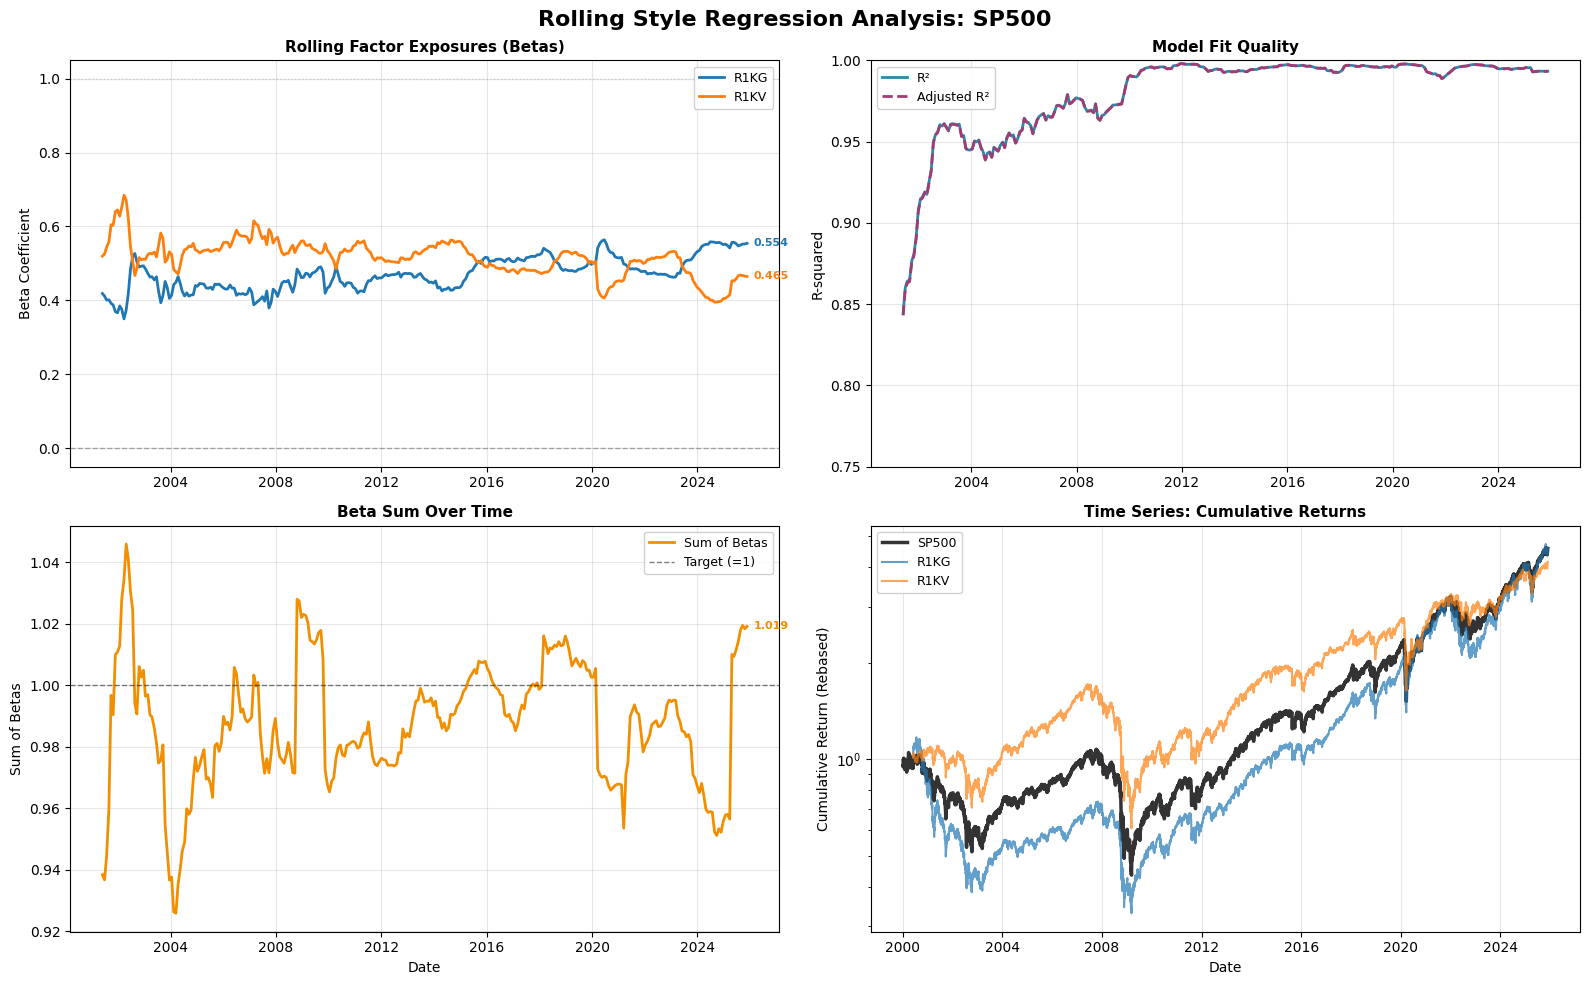

In [58]:

results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = False,
    long_only = False
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = False,
    long_only = False      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

### Constrained


Style Regression Results: SP500
 (Constrained Regression: Betas sum to 1)

Model Summary:


,Metric,Value
0,Dependent Variable,SP500
1,Model Type,Constrained (Σβ=1)
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,752
5,R-squared,0.993588
6,Adjusted R-squared,0.993580
7,Sum of Betas,1.000000



Coefficients:


,Variable,Beta,P-value,Significance
0,R1KG,0.551088,None,
1,R1KV,0.448912,None,


,n_obs,rsquared,adj_rsquared,R1KG_beta,R1KV_beta
date,,,,,
2025-07-23,251,0.993204,0.993177,0.550119,0.449881
2025-08-22,251,0.993077,0.993049,0.552604,0.447396
2025-09-19,251,0.993025,0.992997,0.555215,0.444785
2025-10-21,251,0.993034,0.993006,0.555574,0.444426
2025-11-20,251,0.993066,0.993038,0.558144,0.441856


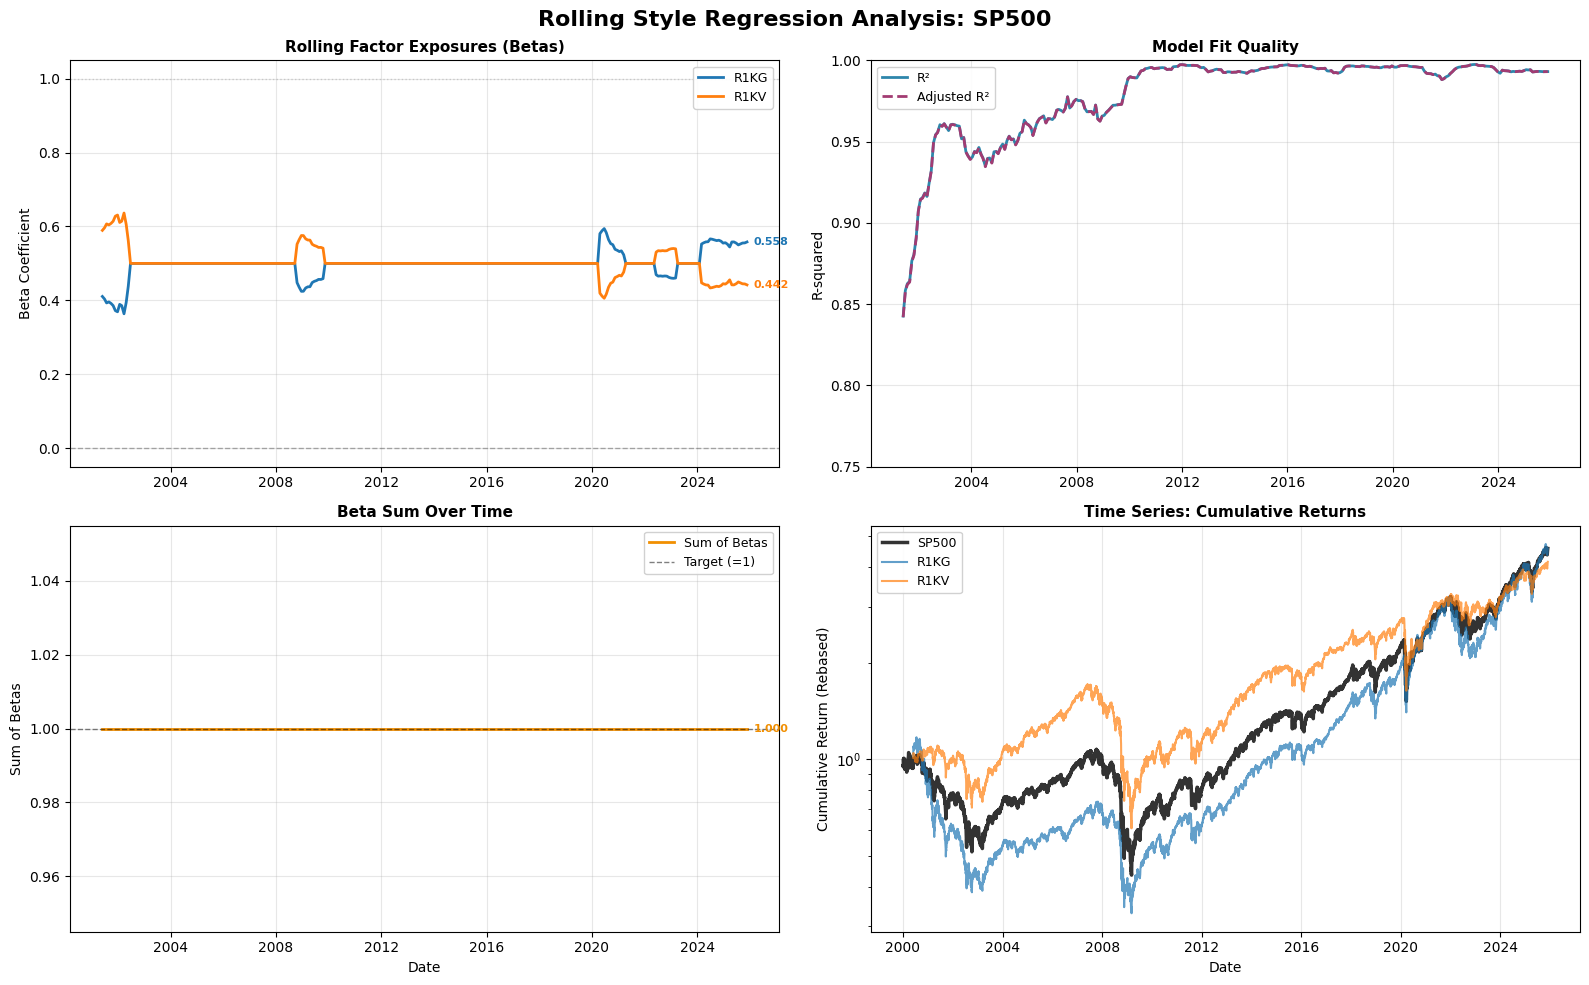

In [59]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = True,
    long_only = True
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = True,
    long_only = True      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

## Russell Mid Cap by Russell Mid Cap Value and Russell Mid Cap Growth

In [60]:
DEP_VAR = 'RMC'
INDEP_VARS = ['RMCG', 'RMCV']

### Unconstrained


Style Regression Results: RMC

Model Summary:


,Metric,Value
0,Dependent Variable,RMC
1,Model Type,Unconstrained OLS
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.997761
6,Adjusted R-squared,0.997755
7,F-statistic,167306.955406
8,F-statistic p-value,1.110223e-16
9,Intercept,0.000014



Coefficients:


,Variable,Beta,P-value,Significance
0,RMCG,0.281913,0.0,***
1,RMCV,0.716026,0.0,***



Significance levels: * p<0.05, ** p<0.01, *** p<0.001



,n_obs,rsquared,adj_rsquared,RMCG_beta,RMCG_pval,RMCV_beta,RMCV_pval
date,,,,,,,
2025-07-15,251,0.998438,0.998425,0.258367,0.0,0.747211,0.0
2025-08-14,251,0.998544,0.998533,0.259553,0.0,0.745212,0.0
2025-09-12,251,0.998606,0.998595,0.262305,0.0,0.742980,0.0
2025-10-13,250,0.998694,0.998683,0.262318,0.0,0.742722,0.0
2025-11-12,251,0.998728,0.998718,0.262459,0.0,0.742540,0.0


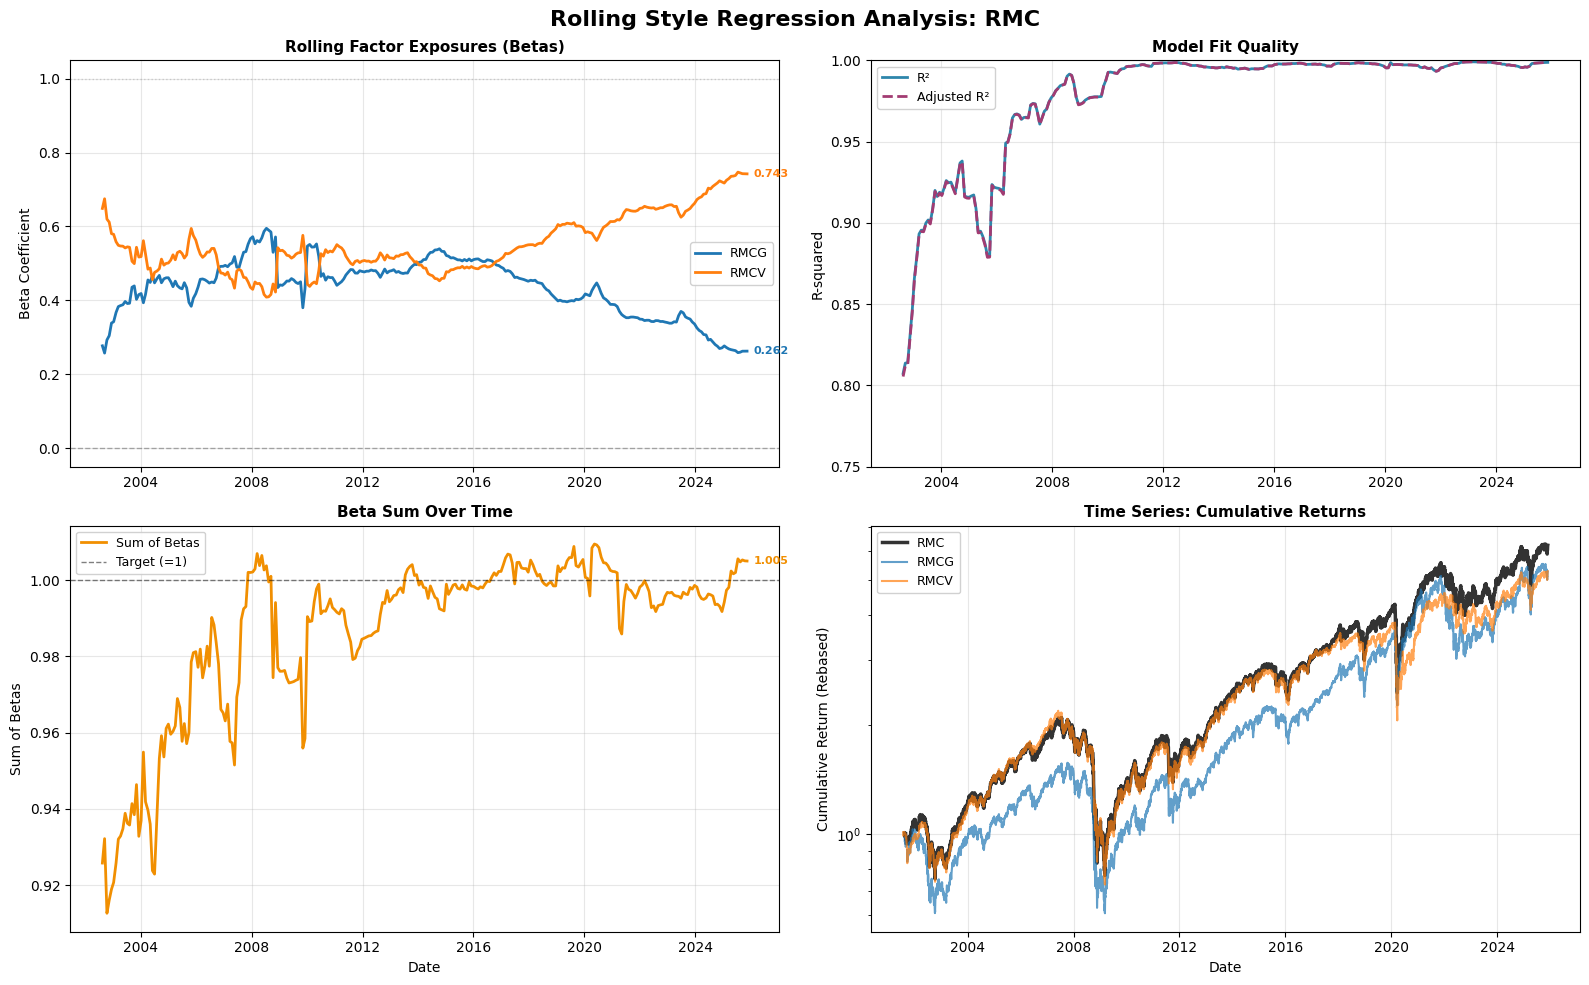

In [61]:

results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = False,
    long_only = False
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = False,
    long_only = False      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

### Constrained


Style Regression Results: RMC
 (Constrained Regression: Betas sum to 1)

Model Summary:


,Metric,Value
0,Dependent Variable,RMC
1,Model Type,Constrained (Σβ=1)
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.997755
6,Adjusted R-squared,0.997752
7,Sum of Betas,1.000000



Coefficients:


,Variable,Beta,P-value,Significance
0,RMCG,0.281621,None,
1,RMCV,0.718379,None,


,n_obs,rsquared,adj_rsquared,RMCG_beta,RMCV_beta
date,,,,,
2025-07-15,251,0.998413,0.998407,0.260964,0.739036
2025-08-14,251,0.998526,0.998520,0.261520,0.738480
2025-09-12,251,0.998583,0.998577,0.264167,0.735833
2025-10-13,250,0.998673,0.998667,0.264149,0.735851
2025-11-12,251,0.998707,0.998702,0.264265,0.735735


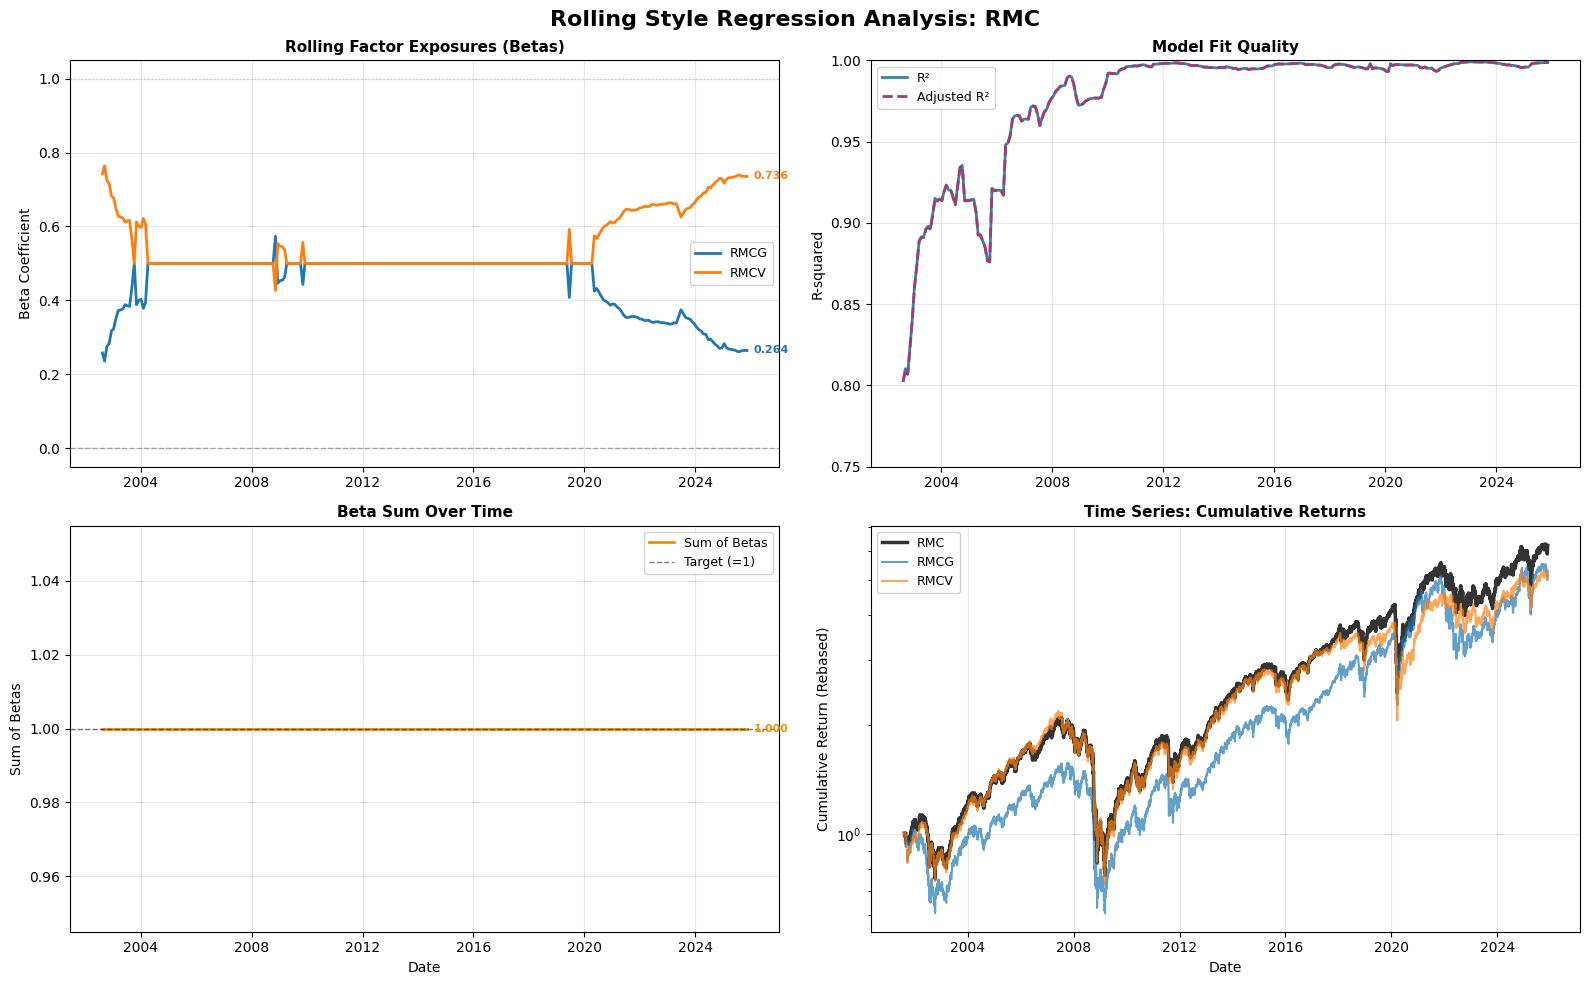

In [62]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = True,
    long_only = True
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = True,
    long_only = True      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

## Russell 3000 by S&P500, Russell Mid Cap, and Russell 2000

In [63]:
DEP_VAR = 'R3K'
INDEP_VARS = ['SP500', 'RMC', 'R2K']

### Unonstrained


Style Regression Results: R3K

Model Summary:


,Metric,Value
0,Dependent Variable,R3K
1,Model Type,Unconstrained OLS
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.995315
6,Adjusted R-squared,0.995296
7,F-statistic,53110.903398
8,F-statistic p-value,1.110223e-16
9,Intercept,0.000020



Coefficients:


,Variable,Beta,P-value,Significance
0,SP500,0.860382,0.000000e+00,***
1,RMC,0.063450,4.923173e-12,***
2,R2K,0.067438,0.000000e+00,***



Significance levels: * p<0.05, ** p<0.01, *** p<0.001



,n_obs,rsquared,adj_rsquared,SP500_beta,SP500_pval,RMC_beta,RMC_pval,R2K_beta,R2K_pval
date,,,,,,,,,
2025-07-14,250,0.994559,0.994493,0.847796,0.0,0.052338,0.009519,0.076098,1.227574e-10
2025-08-13,251,0.994400,0.994332,0.854314,0.0,0.044081,0.023577,0.075238,4.423932e-10
2025-09-12,251,0.994447,0.994379,0.852782,0.0,0.045152,0.018132,0.074690,6.181400e-10
2025-10-10,251,0.994546,0.994480,0.853927,0.0,0.042023,0.026127,0.075974,3.250502e-10
2025-11-11,251,0.994507,0.994440,0.854942,0.0,0.046004,0.011527,0.070493,6.818698e-09


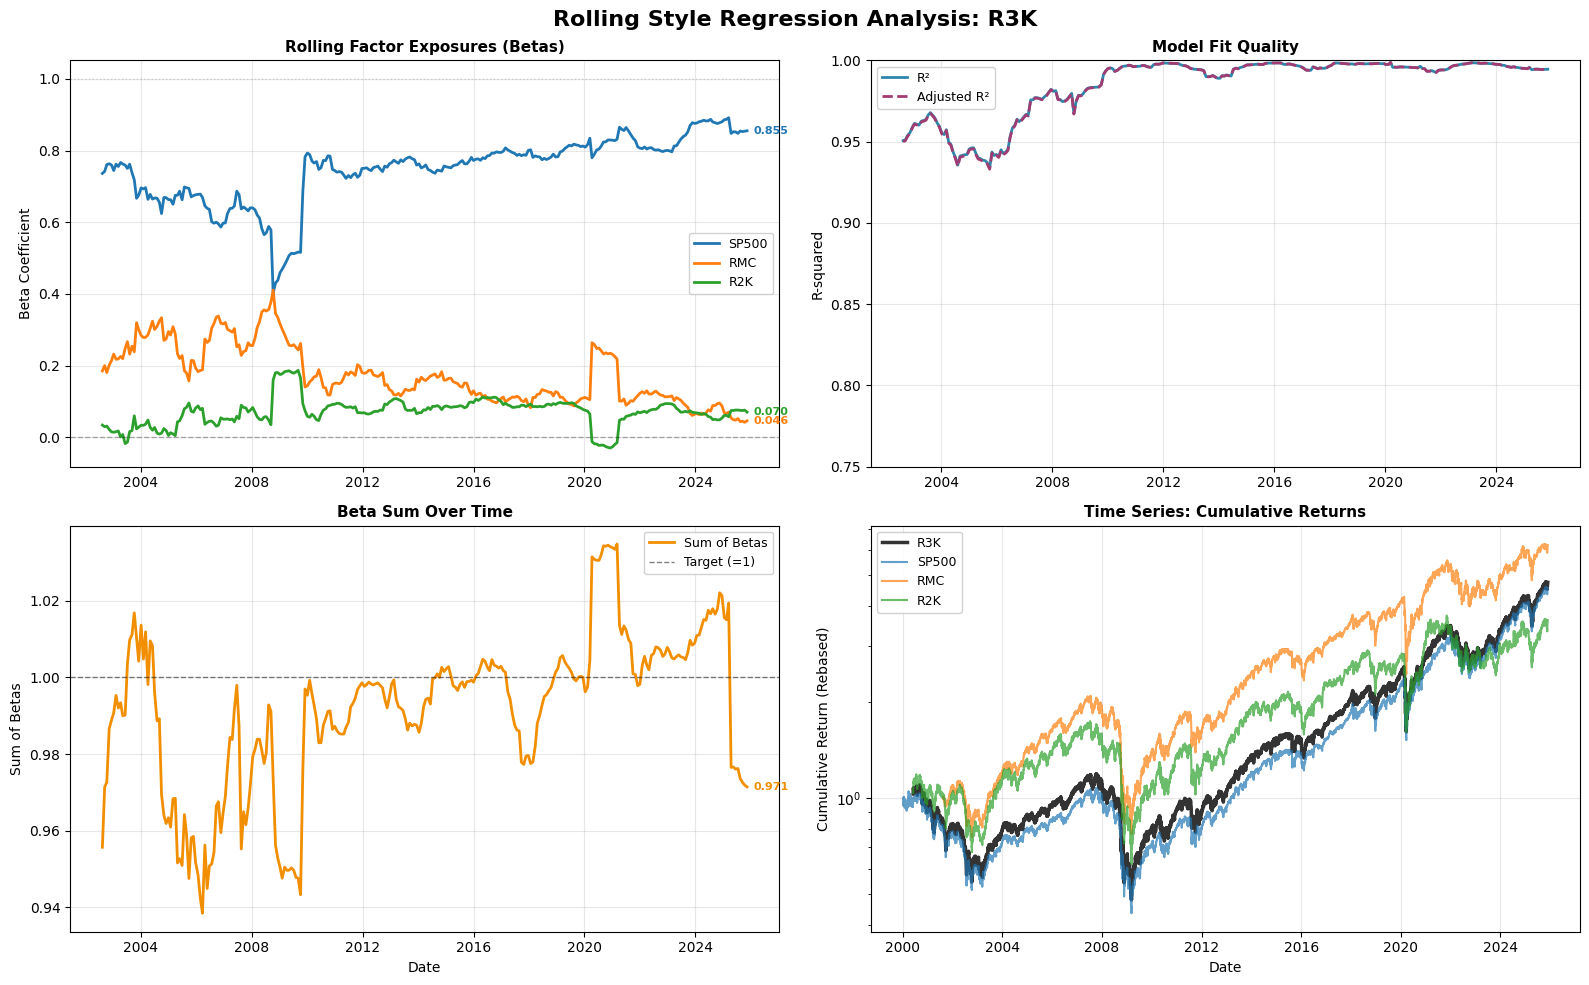

In [64]:

results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = False,
    long_only = False
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = False,
    long_only = False      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

### Constrained


Style Regression Results: R3K
 (Constrained Regression: Betas sum to 1)

Model Summary:


,Metric,Value
0,Dependent Variable,R3K
1,Model Type,Constrained (Σβ=1)
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.995245
6,Adjusted R-squared,0.995232
7,Sum of Betas,1.000000



Coefficients:


,Variable,Beta,P-value,Significance
0,SP500,0.868127,None,
1,RMC,0.071245,None,
2,R2K,0.060629,None,


,n_obs,rsquared,adj_rsquared,SP500_beta,RMC_beta,R2K_beta
date,,,,,,
2025-07-14,250,0.994070,0.994022,0.853357,0.091204,0.055439
2025-08-13,251,0.993774,0.993724,0.864514,0.081820,0.053665
2025-09-12,251,0.993753,0.993703,0.865610,0.080742,0.053648
2025-10-10,251,0.993818,0.993768,0.867150,0.077943,0.054907
2025-11-11,251,0.993748,0.993698,0.867777,0.081187,0.051036


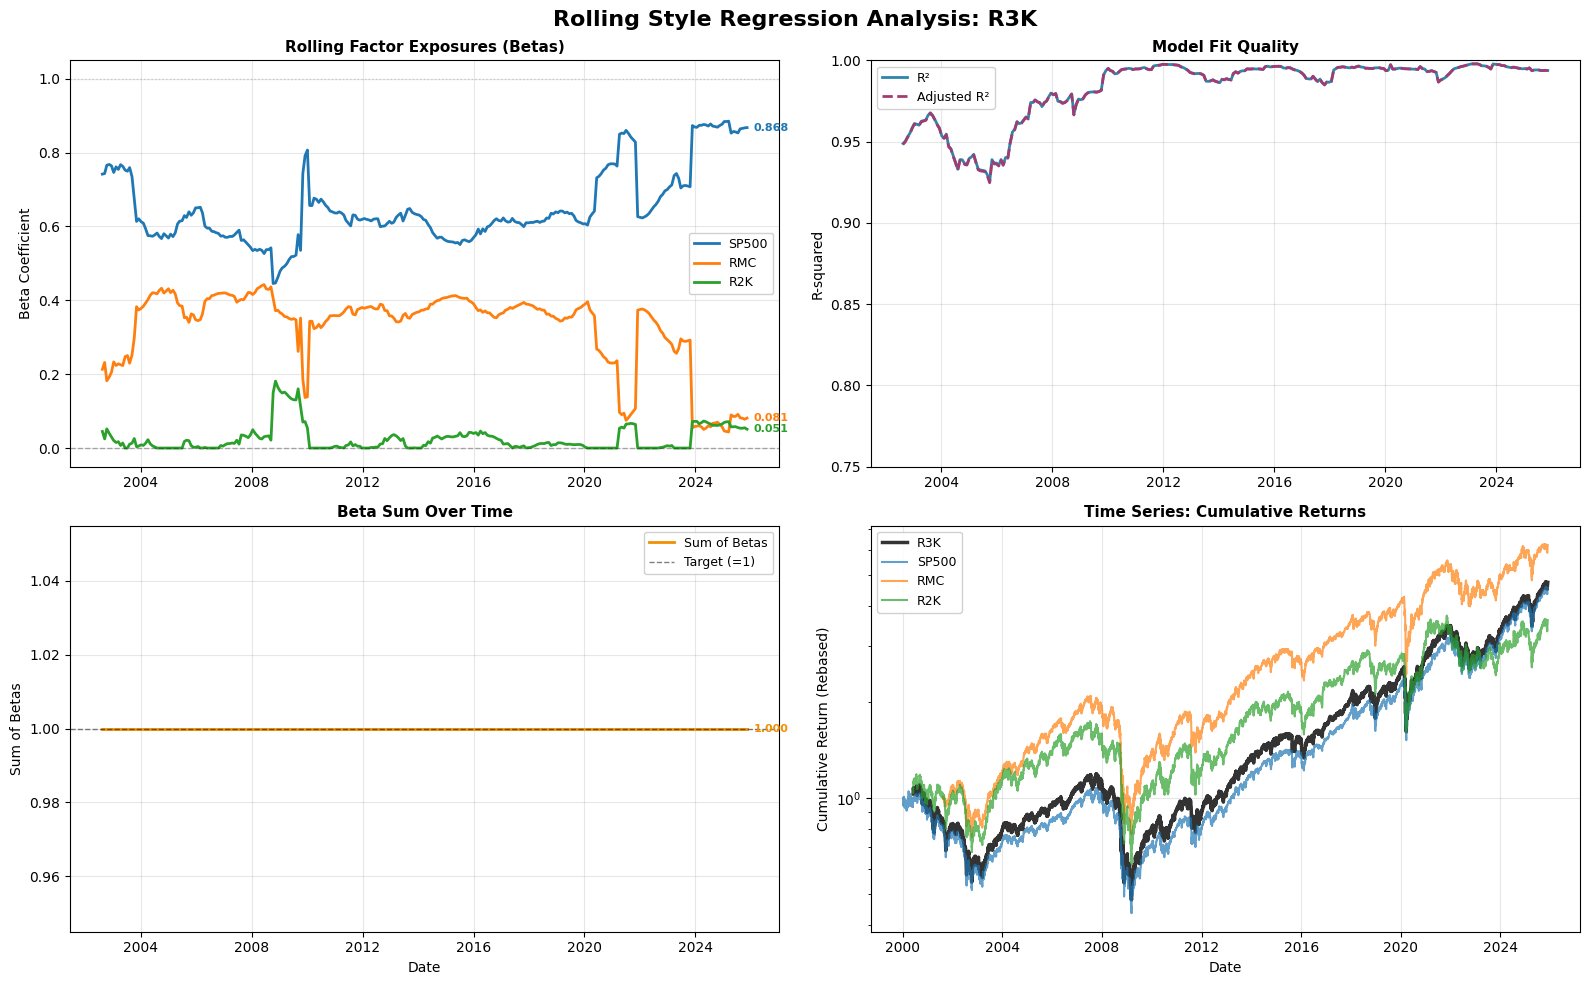

In [65]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = True,
    long_only = True
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = True,
    long_only = True      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

## MSCI ACWI by S&P500, Russell Mid Cap, Russell 2000, EM, and EAFE

In [66]:
DEP_VAR = 'ACWI'
INDEP_VARS = ['SP500', 'RMC', 'R2K', 'EM', 'INT']

### Unconstrained


Style Regression Results: ACWI

Model Summary:


,Metric,Value
0,Dependent Variable,ACWI
1,Model Type,Unconstrained OLS
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.996575
6,Adjusted R-squared,0.996552
7,F-statistic,43531.530533
8,F-statistic p-value,1.110223e-16
9,Intercept,0.000014



Coefficients:


,Variable,Beta,P-value,Significance
0,SP500,0.614463,0.000000,***
1,RMC,0.015754,0.030167,*
2,R2K,0.012973,0.001717,**
3,EM,0.115858,0.000000,***
4,INT,0.231535,0.000000,***



Significance levels: * p<0.05, ** p<0.01, *** p<0.001



,n_obs,rsquared,adj_rsquared,SP500_beta,SP500_pval,RMC_beta,RMC_pval,R2K_beta,R2K_pval,EM_beta,EM_pval,INT_beta,INT_pval
date,,,,,,,,,,,,,
2025-07-03,251,0.995930,0.995847,0.609601,0.0,0.033487,0.037015,0.006568,0.461046,0.109943,0.0,0.219215,0.0
2025-08-04,250,0.995802,0.995716,0.602219,0.0,0.043715,0.007513,0.004943,0.602870,0.110481,0.0,0.215083,0.0
2025-09-03,251,0.995575,0.995484,0.606626,0.0,0.037413,0.018107,0.006738,0.474038,0.111012,0.0,0.214415,0.0
2025-10-03,251,0.995297,0.995201,0.608055,0.0,0.032425,0.043837,0.009576,0.324068,0.110442,0.0,0.214787,0.0
2025-10-31,251,0.995409,0.995315,0.613322,0.0,0.025409,0.103157,0.012076,0.205333,0.114811,0.0,0.210139,0.0


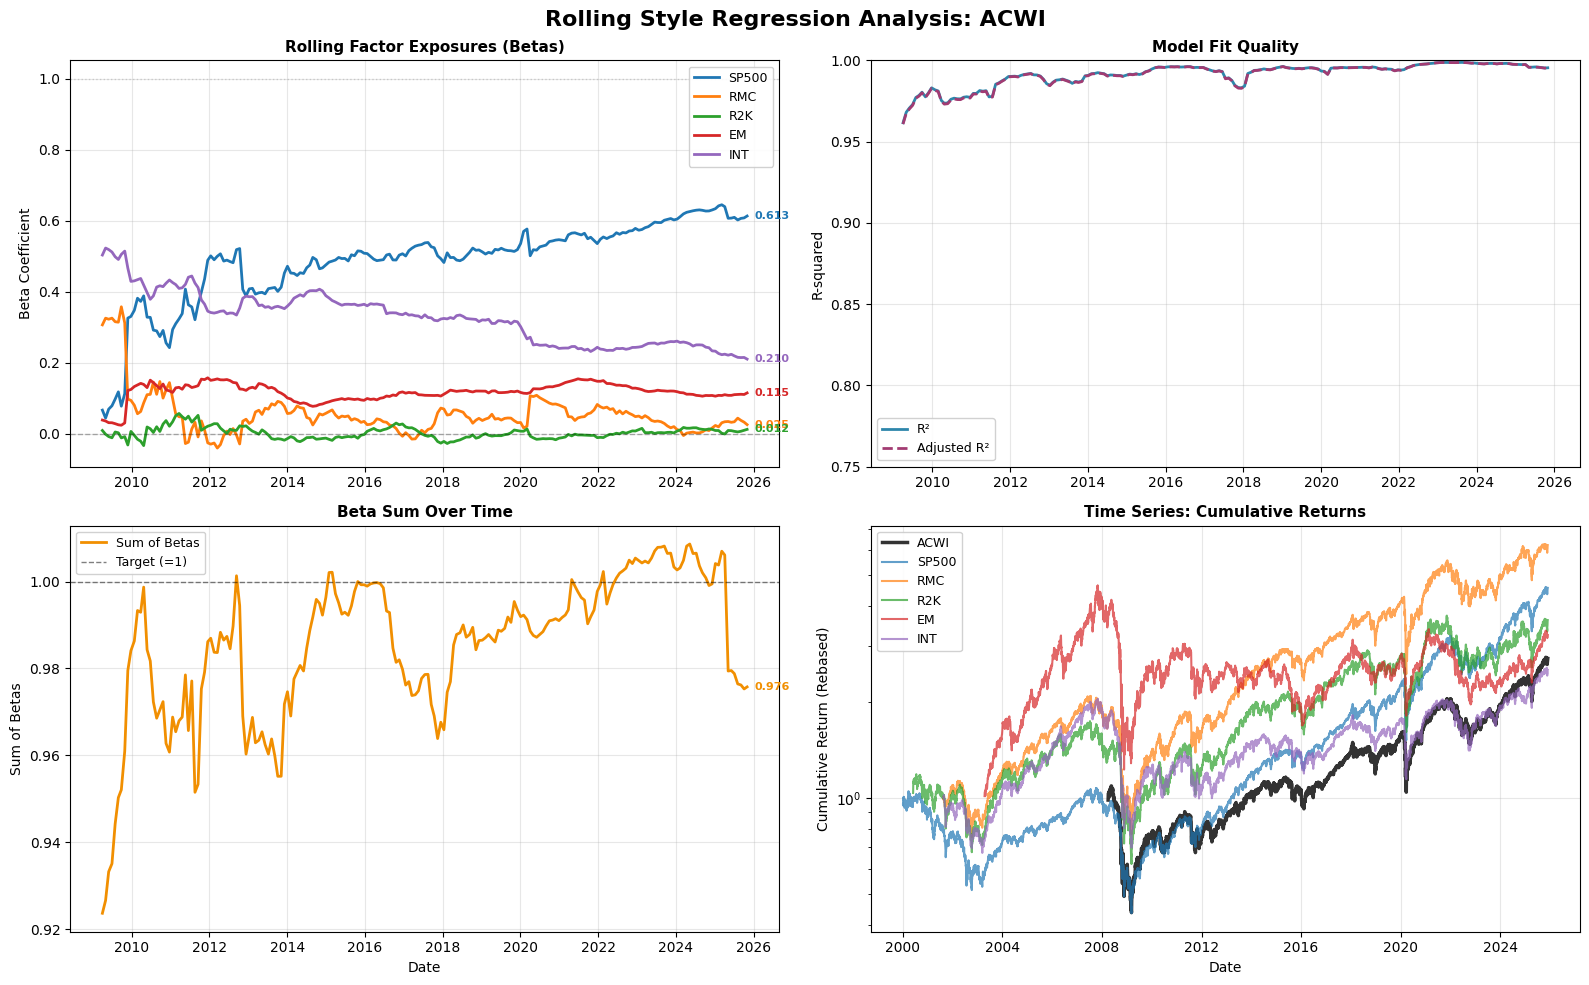

In [67]:

results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = False,
    long_only = False
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = False,
    long_only = False      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

### Constrained


Style Regression Results: ACWI
 (Constrained Regression: Betas sum to 1)

Model Summary:


,Metric,Value
0,Dependent Variable,ACWI
1,Model Type,Constrained (Σβ=1)
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,754
5,R-squared,0.996485
6,Adjusted R-squared,0.996466
7,Sum of Betas,1.000000



Coefficients:


,Variable,Beta,P-value,Significance
0,SP500,0.616126,None,
1,RMC,0.030882,None,
2,R2K,0.002229,None,
3,EM,0.119703,None,
4,INT,0.231060,None,


,n_obs,rsquared,adj_rsquared,SP500_beta,RMC_beta,R2K_beta,EM_beta,INT_beta
date,,,,,,,,
2025-07-03,251,0.995534,0.995461,0.613406,0.044160,0.000000e+00,0.109300,0.233134
2025-08-04,250,0.995292,0.995215,0.608195,0.053898,0.000000e+00,0.117165,0.220742
2025-09-03,251,0.995058,0.994977,0.615368,0.046497,0.000000e+00,0.115366,0.222769
2025-10-03,251,0.994748,0.994662,0.612137,0.049154,3.832787e-19,0.112826,0.225883
2025-10-31,251,0.994905,0.994822,0.613310,0.044093,0.000000e+00,0.123617,0.218979


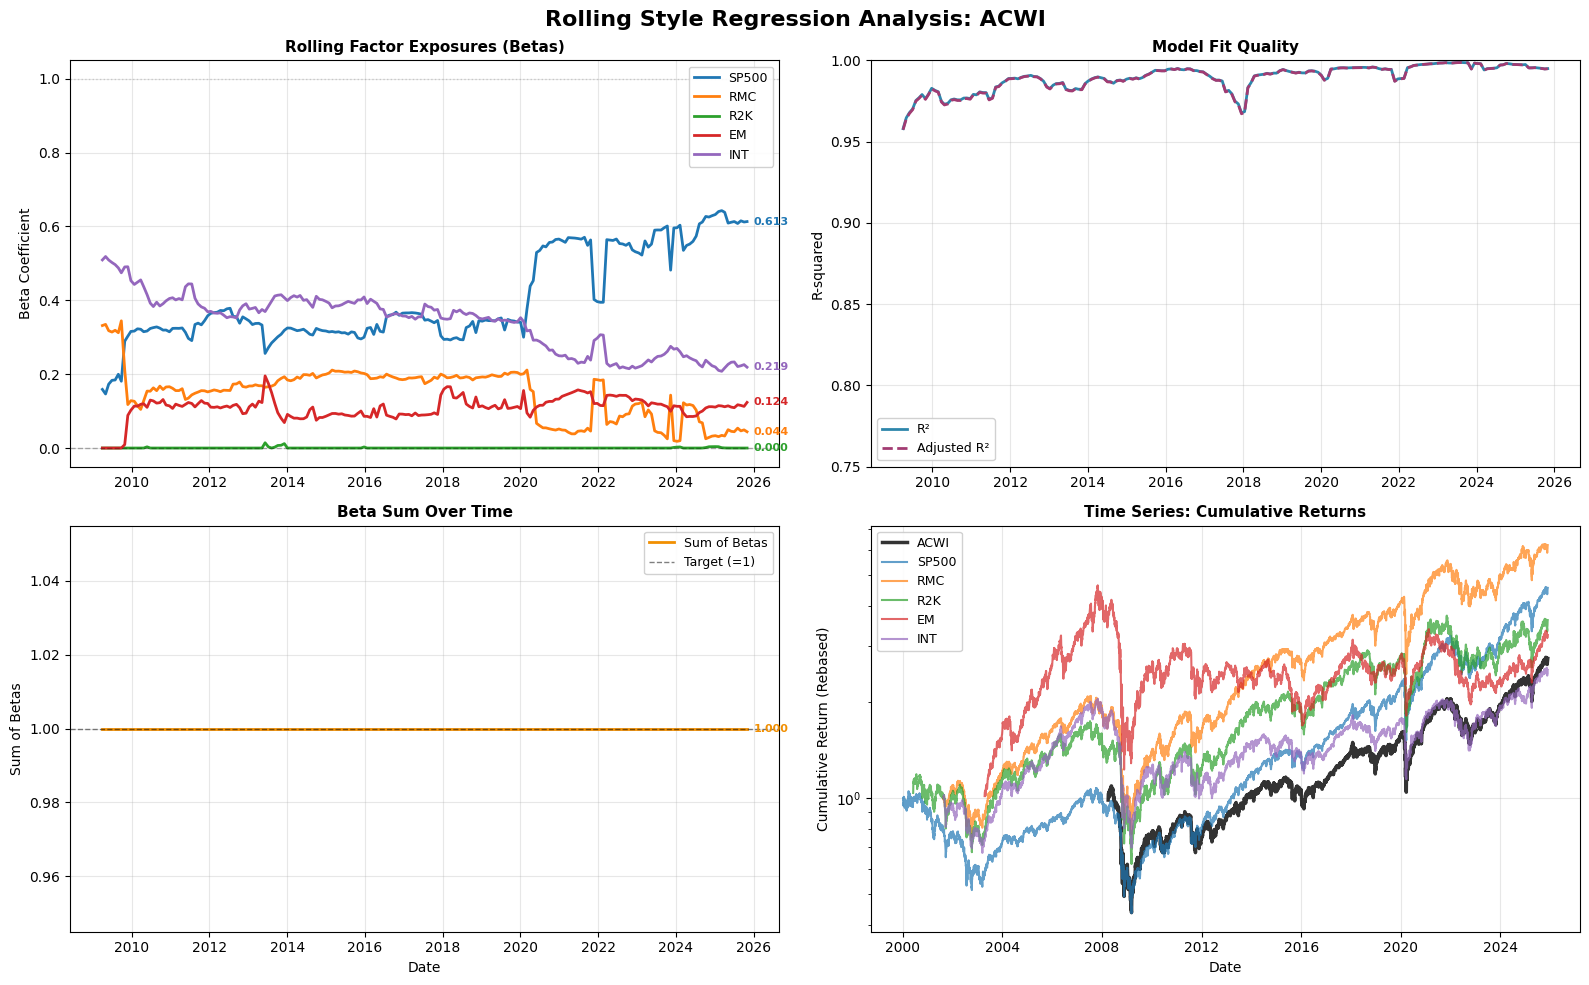

In [68]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = True,
    long_only = True
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = True,
    long_only = True      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

## Russell 2500 by Russell Mid Cap and Russell Small Cap

In [69]:
DEP_VAR = 'R25K'
INDEP_VARS = ['RMC', 'R2K']

### Unconstrained


Style Regression Results: R25K

Model Summary:


,Metric,Value
0,Dependent Variable,R25K
1,Model Type,Unconstrained OLS
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,752
5,R-squared,0.990032
6,Adjusted R-squared,0.990006
7,F-statistic,37196.993932
8,F-statistic p-value,1.110223e-16
9,Intercept,-0.000026



Coefficients:


,Variable,Beta,P-value,Significance
0,RMC,0.477950,0.0,***
1,R2K,0.552563,0.0,***



Significance levels: * p<0.05, ** p<0.01, *** p<0.001



,n_obs,rsquared,adj_rsquared,RMC_beta,RMC_pval,R2K_beta,R2K_pval
date,,,,,,,
2025-07-03,251,0.992352,0.992291,0.470678,0.0,0.567136,0.0
2025-08-01,251,0.991920,0.991855,0.469285,0.0,0.566232,0.0
2025-08-29,251,0.990995,0.990922,0.469513,0.0,0.564745,0.0
2025-10-01,251,0.990644,0.990569,0.465021,0.0,0.569998,0.0
2025-10-31,251,0.990628,0.990552,0.469478,0.0,0.566630,0.0


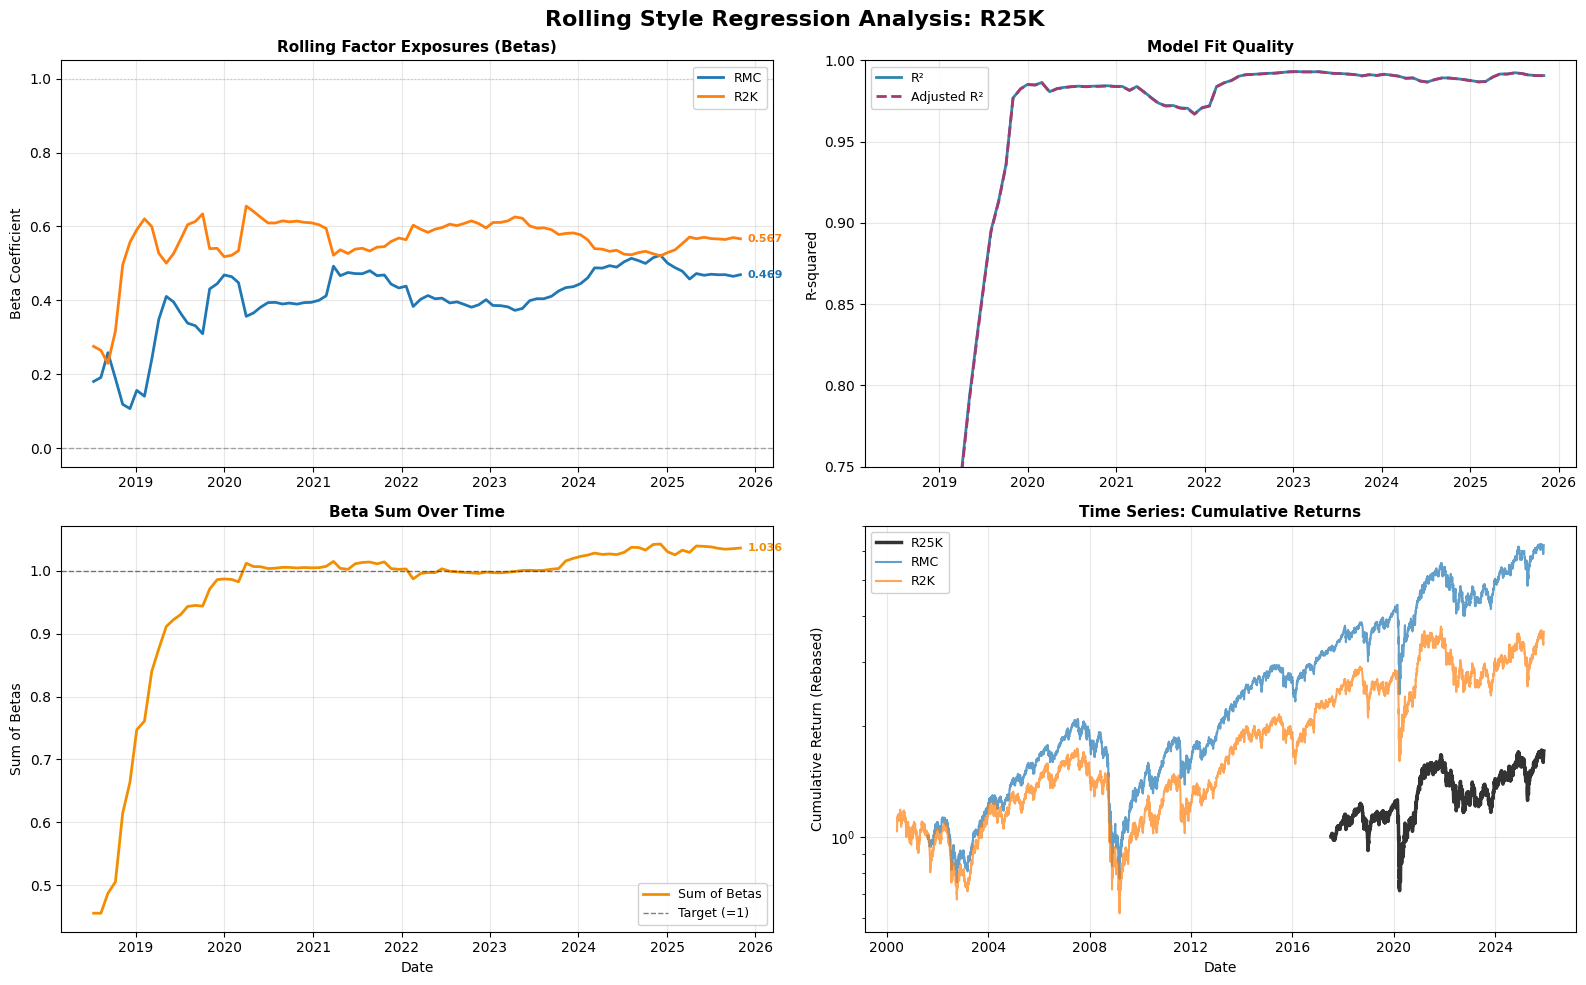

In [70]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = False,
    long_only = False
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = False,
    long_only = False      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)

### Constrained


Style Regression Results: R25K
 (Constrained Regression: Betas sum to 1)

Model Summary:


,Metric,Value
0,Dependent Variable,R25K
1,Model Type,Constrained (Σβ=1)
2,Period Start,2022-11-28
3,Period End,2025-11-28
4,Observations,752
5,R-squared,0.989477
6,Adjusted R-squared,0.989463
7,Sum of Betas,1.000000



Coefficients:


,Variable,Beta,P-value,Significance
0,RMC,0.422204,None,
1,R2K,0.577796,None,


,n_obs,rsquared,adj_rsquared,RMC_beta,R2K_beta
date,,,,,
2025-07-03,251,0.991422,0.991388,0.40321,0.59679
2025-08-01,251,0.989796,0.989755,0.50000,0.50000
2025-08-29,251,0.989025,0.988981,0.50000,0.50000
2025-10-01,251,0.988524,0.988478,0.50000,0.50000
2025-10-31,251,0.988503,0.988457,0.50000,0.50000


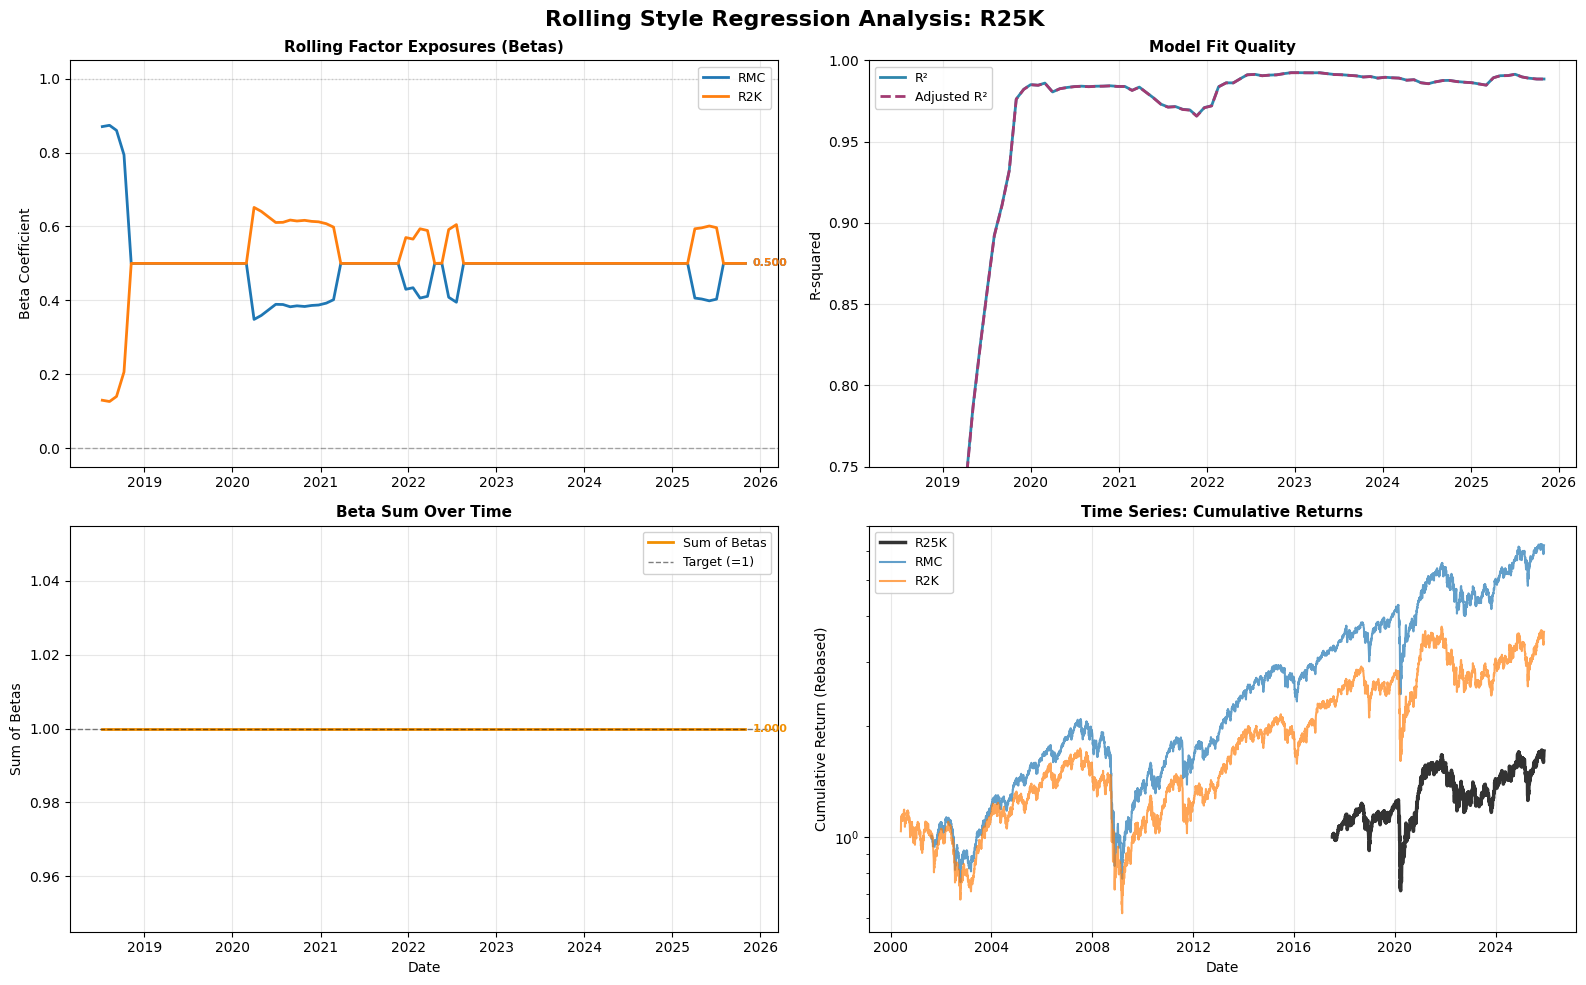

In [71]:
results = style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS, 
    years= 3, 
    constrained = True,
    long_only = True
)
print_regression_results(results, DEP_VAR)


rolling_results = rolling_style_regression(
    returns_df=returns,
    dependent_var=DEP_VAR,
    independent_vars=INDEP_VARS,
    window_years=1,
    step_days=30,
    constrained = True,
    long_only = True      
)
display(rolling_results.tail())

plot_rolling_analysis(
    rolling_results, 
    returns, 
    dependent_var=DEP_VAR, 
    independent_vars=INDEP_VARS
)